<DIV ALIGN=CENTER>

# Introduction to Practical Concepts
## Professor Robert J. Brunner
  
</DIV>  
-----
-----


## Introduction

In this IPython Notebook, we explore several practical concepts that relate to real-world machine learning.

1. Feature Selection
2. Feature Scaling
3. Pipelining
4. Validation/Learning Curves
5. Grid Search
6. Cross Validation

Lets start with Iris and go from there.


Other topics?

-----

-----

## Student Activity

In the preceding cells, we used Kernel Density Estimation to build a
model representation of the digit data and to subsequently sample from
this model to make new digit images. Now that you have run the Notebook,
go back and make the following changes to see how the results change.

1. Change the number of PCA components lower and higher. How does this
affect the fidelity of the new digit images?
2. Change the bandwidth used in the KDE estimator. How does this affect
the fidelity of the new digit images?
3. Try using a different kernel function, for example a `exponential` or
`epanechnikov`. How does this affect the fidelity of the new digit images?

Finally, try applying a classifier on the new digit data. Can you
explain (feel free to use the class forums) why the classification
algorithm performed in the  manner it did for the new _fake_ digits?

-----

In [1]:
# Set up Notebook

% matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


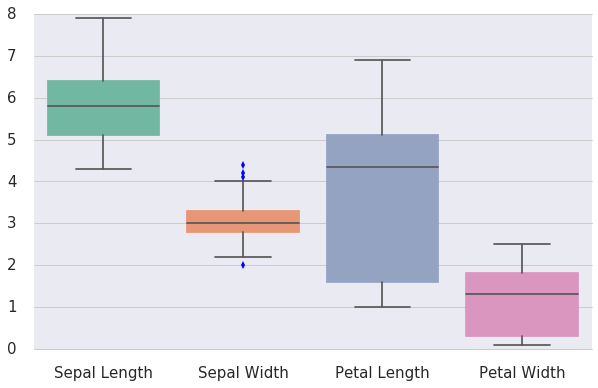

In [2]:
iris = sns.load_dataset('iris')
# Make a box plot to show distributions
fig, axs = plt.subplots(figsize=(10,6))
sns.set(style="white", font_scale=1.5)

iris.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']
sns.boxplot(data=iris, orient="v", palette="Set2", ax=axs)
sns.despine(offset=10)

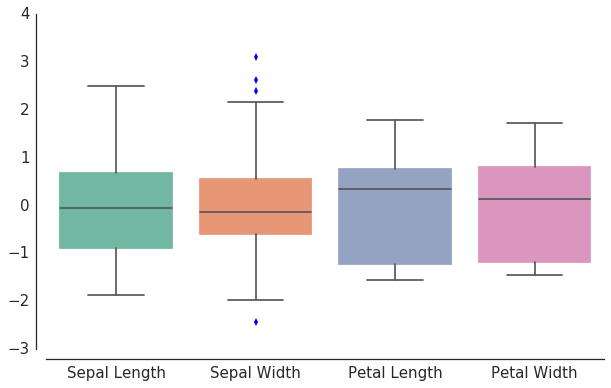

In [3]:
from sklearn import preprocessing

# We can scale in different manners
s_iris = pd.DataFrame(preprocessing.scale(iris.values[:,0:4]))
#s_iris = pd.DataFrame(preprocessing.normalize(iris.values[:,0:4]))

# Make a box plot to show distributions
fig, axs = plt.subplots(figsize=(10,6))
sns.set(style="white", font_scale=1.5)

s_iris.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
sns.boxplot(data=s_iris, orient="v", palette="Set2", ax=axs)
sns.despine(offset=10)

In [4]:
from sklearn import svm
from sklearn import cross_validation as cv
from sklearn.metrics import classification_report

# Get our original data
x = iris.values[:,0:4]
y = np.array([i//50 for i in range(iris.shape[0])])

# Get training and tesign data
(x_train, x_test, y_train, y_test) = cv.train_test_split(x, y, test_size=.25)

# Next lets try Linear SVM
svc = svm.SVC(kernel='linear', C=0.1)

# Compute scaling from training data only
ps = preprocessing.StandardScaler().fit(x_train)

# Now transformt the input training and testing data
xs_train = ps.transform(x_train)
xs_test = ps.transform(x_test)

# Fit and Predict
svc.fit(xs_train, y_train)
y_pred = svc.predict(xs_test)

print("SVM prediction accuracy = {0:5.1f}%".format(100.0 * svc.score(xs_test, y_test)))
print(classification_report(y_test, y_pred, \
                            target_names = ['Setosa', 'Versicolor', 'Virginica']))

SVM prediction accuracy =  92.1%
             precision    recall  f1-score   support

     Setosa       1.00      1.00      1.00         7
 Versicolor       0.81      1.00      0.90        13
  Virginica       1.00      0.83      0.91        18

avg / total       0.94      0.92      0.92        38



-----
## Feature Selection

Why?

The Recursive Feature Elimination (RFE) method is a feature selection approach. It works by recursively removing attributes and building a model on those attributes that remain. It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

This recipe shows the use of RFE on the Iris floweres dataset to select 3 attributes.

-----

In [5]:
from sklearn.feature_selection import RFE

# Number of attributes to keep
num_attributes = 3

# Create RFE model with target number of attributes
rfe = RFE(svc, num_attributes)
rfe = rfe.fit(x, y)
     
for idx, label in enumerate(s_iris.columns):
    if rfe.support_[idx]:
        print('Kept   : {0}'.format(label))
    else:
        print('Dropped: {0}'.format(label))

Dropped: Sepal Length
Kept   : Sepal Width
Kept   : Petal Length
Kept   : Petal Width


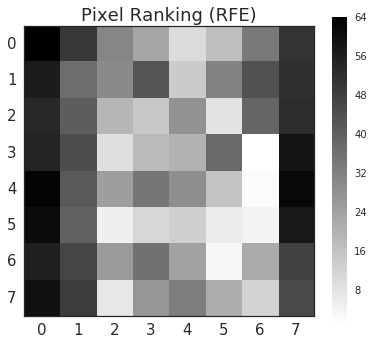

In [6]:
# We have helper code to assist in the loading and plotting of these data
from helper_code import digits as hd

# We extract features (x), labels (y), and the images for plotting.
x, y, images = hd.get_data()

from sklearn.feature_selection import RFE

# Create the RFE estimator
svc = svm.SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=1, step=1)

# Compute the pixel rankings
rfe.fit(x, y)
ranking = rfe.ranking_.reshape(images[0].shape)

# Plot the result
fig, axs = plt.subplots(figsize=(6.5, 5.5))
sns.set(style='dark', font_scale=1.0)
plt.gray()
plt.imshow(ranking, interpolation='nearest', cmap=plt.cm.gray_r)
plt.colorbar()
sns.set(style='dark', font_scale=1.5)
plt.title("Pixel Ranking (RFE)")
plt.show()

In [7]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# Build model
rfc = RandomForestClassifier()
rfc.fit(xs_train, y_train)

# Display attributes in ranked order
print('{0:14s}: Importance'.format('Label'))
print(26*'-')
for val, label in zip(rfc.feature_importances_, s_iris.columns):
    print('{0:14s}: {1:04.2f}%'.format(label, 100.0 * val))

Label         : Importance
--------------------------
Sepal Length  : 0.62%
Sepal Width   : 4.46%
Petal Length  : 52.07%
Petal Width   : 42.86%


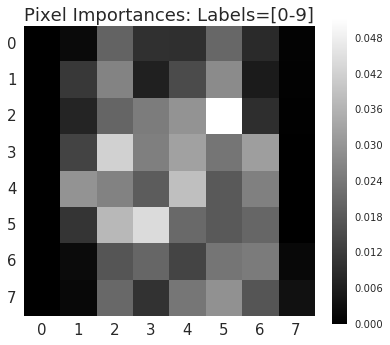

In [8]:
# We can restrict the classes (digit labels)
# By default, we keep themn all 0-9
minc = 0 ; maxc = 10
mask = (y >= minc) & (y < maxc)  # Limit classes
x = x[mask]
y = y[mask]

# Build Randomf Forest
rfc = RandomForestClassifier(n_estimators=1000, max_features=8)
rfc.fit(x, y)

imptcs = rfc.feature_importances_
imptcs = imptcs.reshape(images[0].shape)

# Plot the result
fig, axs = plt.subplots(figsize=(6.5, 5.5))
sns.set(style='dark', font_scale=1.0)
plt.gray()
plt.imshow(imptcs, interpolation='nearest')
plt.colorbar()
sns.set(style='dark', font_scale=1.5)
plt.title("Pixel Importances: Labels=[{0:d}-{1:d}]".format(minc, maxc-1))
plt.show()

------

## Pipeline

http://scikit-learn.org/stable/auto_examples/plot_digits_pipe.html

----

Anova SVM Score = 83.7%


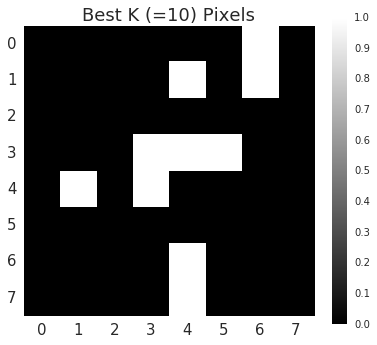

In [9]:
# Modified code from scikit example:
# http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline

# Number of pixels to keep
k = 10

# ANOVA SVM-C
anova = SelectKBest(f_regression, k=5)
svc = svm.SVC(kernel='linear')

# Create a pipeline, with names for pipe elements
anova_svm = Pipeline([('anova', anova), ('svc', svc)])

# You can set the parameters using the names
anova_svm.set_params(anova__k=k, svc__C=.1).fit(x, y)

# Apply Anova SVM
prediction = anova_svm.predict(x)
print('Anova SVM Score = {0:4.1f}%'.format(100.0* anova_svm.score(x, y)))

# Grab the best k pixels as chosen by Anova SVM
pixels = np.array(anova_svm.named_steps['anova'].get_support(), dtype=np.int8)
pixels = np.reshape(pixels, images[0].shape)

# Plot the result
fig, axs = plt.subplots(figsize=(6.5, 5.5))
sns.set(style='dark', font_scale=1.0)
plt.gray()
plt.imshow(pixels, interpolation='nearest')
plt.colorbar()
sns.set(style='dark', font_scale=1.5)
plt.title("Best K (={0:d}) Pixels".format(k))
plt.show()

----

## CV

http://scikit-learn.org/stable/tutorial/statistical_inference/model_selection.html#model-selection-tut

Cross-validation generators
KFold (n, k)	StratifiedKFold (y, k)	LeaveOneOut (n)	LeaveOneLabelOut (labels)
Split it K folds, train on K-1 and then test on left-out	It preserves the class ratios / label distribution within each fold.	Leave one observation out	Takes a label array to group observations



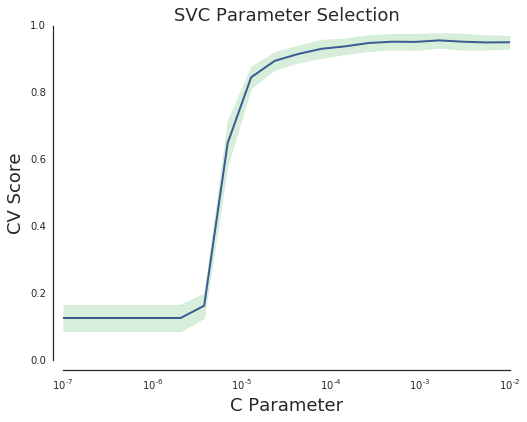

In [10]:
# Modified scikit Learn example:
# http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_digits.html

# Create our k-Fold instance
from sklearn.cross_validation import KFold
kf = KFold(len(x), n_folds=5)

# Create classifier/sample parameter values
svc = svm.SVC(kernel='linear')
c_vals = np.logspace(-7, -2, 20)

# Loop over parameter values to accumulate statistics
scr_mu = list()
scr_sig = list()
for c in c_vals:
    svc.C = c
    score = cv.cross_val_score(svc, x, y, cv=kf)
    scr_mu.append(np.mean(score))
    scr_sig.append(np.std(score))

high = np.array(scr_mu) + np.array(scr_sig)
low = np.array(scr_mu) - np.array(scr_sig)

# Plot the results
sns.set(style="white", font_scale=1.0)
fig, ax = plt.subplots(figsize=(8,6))

plt.semilogx(c_vals, scr_mu, color=sns.xkcd_rgb["denim blue"], linewidth=2)
plt.fill_between(c_vals, high, low, color=sns.xkcd_rgb["medium green"], alpha=0.2)
plt.yticks()

plt.ylabel('CV Score', fontsize=18)
plt.xlabel('C Parameter', fontsize=18)
plt.title('SVC Parameter Selection', fontsize=18)

sns.despine(offset=10, trim=True)
plt.show()

-----

## Grid Search

-----

In [11]:
from sklearn.grid_search import GridSearchCV

(x_trn, x_tst, y_trn, y_tst) = cv.train_test_split(x, y, test_size=.2)

c_vals = np.logspace(-7, -2, 25)

clf = GridSearchCV(estimator=svc, param_grid=dict(C=c_vals))

clf.fit(x_trn, y_trn)

print('Best C={0:5.4f}'.format(clf.best_estimator_.C))
print('Best CV Score = {0:4.3f}'.format(clf.best_score_))
print('Test Score = {0:4.3f}'.format(clf.score(x_tst, y_tst)))

Best C=0.0024
Best CV Score = 0.985
Test Score = 0.975


-----
## Validation/Lerning Curves


-----

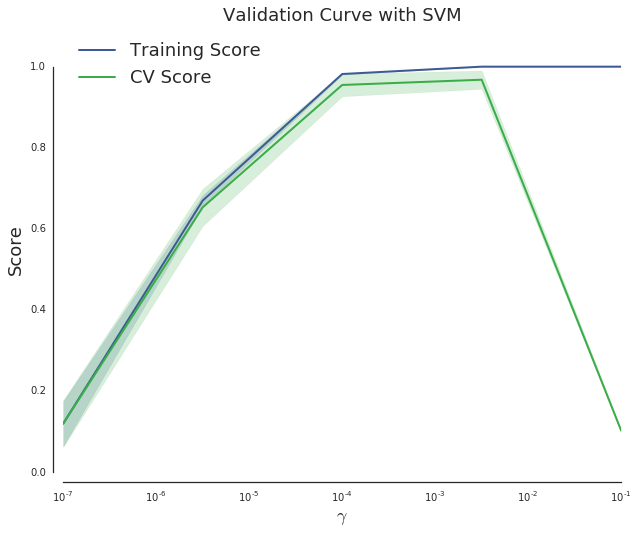

In [12]:
# Modified from scikit learn example:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html

from sklearn.learning_curve import validation_curve
from helper_code import vlcurves

param_range = np.logspace(-7, -1, 5)
trn_scr, tst_scr = validation_curve(svm.SVC(), x, y, param_name="gamma", \
                                    param_range=param_range, cv=10, scoring="accuracy")

y1, y1h, y1l, y2, y2h, y2l = vlcurves.get_range(param_range, trn_scr, tst_scr)

# Plot the results
sns.set(style="white", font_scale=1.0)
fig, ax = plt.subplots(figsize=(10,8))

# Plot data and ranges
trn_color = color=sns.xkcd_rgb["denim blue"]
plt.semilogx(param_range, y1, label="Training Score", lw=2, color=trn_color)
plt.fill_between(param_range, y1h, y1l, alpha=0.2, color=trn_color)

tst_color = color=sns.xkcd_rgb["medium green"]
plt.semilogx(param_range, y2, label="CV Score", lw=2, color=tst_color)
plt.fill_between(param_range, y2h, y2l, alpha=0.2, color=tst_color)

plt.title("Validation Curve with SVM", fontsize=18)
plt.xlabel('$\gamma$', fontsize=18)
plt.ylabel("Score", fontsize=18)
plt.ylim(0.0, 1.1)
plt.legend(loc="best", fontsize=18)

sns.despine(offset=10, trim=True)
plt.show()

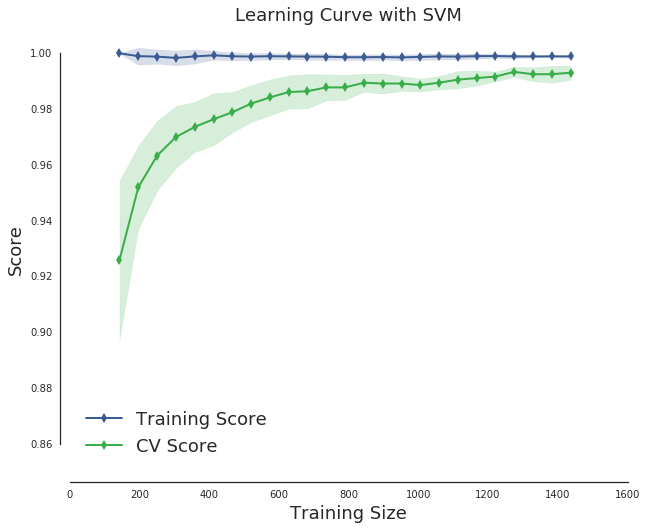

In [13]:
# Modified from scikit learn example:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import ShuffleSplit

trn_sz=np.linspace(0.1, 1, 25)

cv = ShuffleSplit(x.shape[0], n_iter=10, test_size=0.2, random_state=0)

svc = svm.SVC(gamma=0.001)
trn_szs, trn_scr, vld_scr = learning_curve(svc, x, y, cv=cv, train_sizes=trn_sz)

y1, y1h, y1l, y2, y2h, y2l = vlcurves.get_range(trn_szs, trn_scr, vld_scr)

title = 'Learning Curve with SVM'
vlcurves.lv_plot(title, trn_szs, y1, y1h, y1l, y2, y2h, y2l, 'Training Size', 'Score', ylim=(0.85, 1.01))

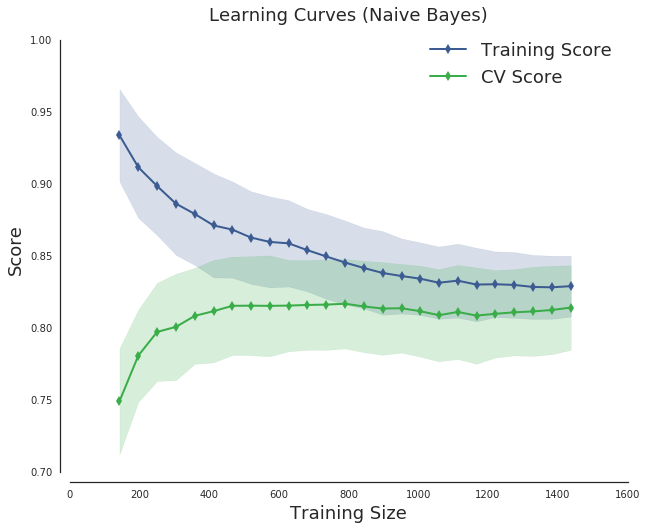

In [14]:
from sklearn.naive_bayes import GaussianNB

cv = ShuffleSplit(x.shape[0], n_iter=100, test_size=0.2)

trn_sz=np.linspace(0.1, 1, 25)

nb = GaussianNB()

trn_szs, trn_scr, vld_scr = learning_curve(nb, x, y, cv=cv, train_sizes=trn_sz)

y1, y1h, y1l, y2, y2h, y2l = vlcurves.get_range(trn_szs, trn_scr, vld_scr)

title = 'Learning Curves (Naive Bayes)'
vlcurves.lv_plot(title, trn_szs, y1, y1h, y1l, y2, y2h, y2l, 'Training Size', 'Score', ylim=(0.7, 1.01))